In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
! pip install captum

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tempfile
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

import ray
import ray.cloudpickle as pickle
from ray import tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray.train import get_checkpoint

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
# ! pip install -U ipywidgets

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input/deep-learning-for-msc-202324/train'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00


2024-02-21 21:47:27,979	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-21 21:47:29,306	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Protein Sequence and Structure Dataset with PyTorch

This code defines a custom PyTorch Dataset class, ProteinDataset, designed to handle protein sequence and structure data for machine learning models. It allows for the loading, processing, and encoding of protein sequences and their corresponding secondary structure labels from CSV files, as well as Position-Specific Scoring Matrix (PSSM) profiles from a specified directory. This dataset class is tailored for tasks such as protein secondary structure prediction, where both the amino acid sequence and evolutionary information (from PSSMs) are crucial for accurate predictions.

In [2]:
class ProteinDataset(Dataset):
    """
    A custom dataset class for handling protein sequences, their corresponding secondary structure labels,
    and Position-Specific Scoring Matrix (PSSM) profiles.
    """
    def __init__(self, seqs_csv, labels_csv=None, pssm_dir=None):
        """
        Initializes the dataset object.
        
        Parameters:
        - seqs_csv: Path to the CSV file containing protein sequences.
        - labels_csv: Optional path to the CSV file containing secondary structure labels.
        - pssm_dir: Directory containing PSSM profiles for the sequences.
        """
        
        # Load sequence and optional label data from CSV files
        self.seqs_data = pd.read_csv(seqs_csv) # Load sequences from CSV
        self.labels_data = pd.read_csv(labels_csv) if labels_csv is not None else None # Load labels if provided
        self.pssm_dir = pssm_dir # Directory where PSSM profiles are stored
        
        # Maps amino acids and structure labels to indices for encoding
        self.aa_to_index = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'E': 5, 'Q': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}
        self.structure_to_index = {'H': 0, 'E': 1, 'C': 2}  # Mapping for structure labels

    def __len__(self):
        """Returns the total number of sequences in the dataset."""
        return len(self.seqs_data)
    
    def encode_structure(self, structure_label):
        """
        Encodes a secondary structure label string into a tensor of numerical indices.
        
        Parameters:
        - structure_label: A string of secondary structure labels.
        
        Returns:
        A tensor of numerical indices corresponding to the secondary structure labels.
        """
        return torch.tensor([self.structure_to_index[label] for label in structure_label], dtype=torch.long)

    def encode_sequence(self, sequence):
        """
        Encodes a protein sequence into a one-hot encoded tensor.
        
        Parameters:
        - sequence: A string of amino acids.
        
        Returns:
        A one-hot encoded tensor representing the sequence.
        """
        encoded = torch.zeros(len(sequence), len(self.aa_to_index))
        for i, aa in enumerate(sequence):
            if aa in self.aa_to_index: # Check if amino acid is recognized
                encoded[i, self.aa_to_index[aa]] = 1
        return encoded
    
    def __getitem__(self, idx):
        """
        Retrieves the encoded sequence, PSSM profile, and optional label for a given index.
        
        Parameters:
        - idx: Index of the item to retrieve.
        
        Returns:
        A tuple containing the encoded sequence tensor, PSSM tensor, optional label tensor, PDB ID, and sequence length.
        """
        
        # Retrieve sequence and PDB ID
        pdb_id = self.seqs_data.iloc[idx]['PDB_ID']
        sequence = self.seqs_data.iloc[idx]['SEQUENCE']
        mode = "train" # Assume training mode by default
        
        # Load and encode labels if available
        if self.labels_data is not None:
            label_str = self.labels_data[self.labels_data['PDB_ID'] == pdb_id]['SEC_STRUCT'].values[0]
            label = self.encode_structure(label_str)  # Encode the label
        else:
            label = None
            mode = "test"
        
        # Load and process PSSM profile
        pssm_path = os.path.join(self.pssm_dir, f"{pdb_id}_{mode}.csv")
        pssm_profile = pd.read_csv(pssm_path)
        # Ensure PSSM profile is numeric and handle potential non-numeric values
        pssm_profile = pssm_profile.apply(pd.to_numeric, errors='coerce').fillna(0).values[:, 2:]  # Convert non-numeric to NaN, fill with 0
        
        
        # Encode sequence and convert PSSM profile to tensors
        sequence_encoded = self.encode_sequence(sequence)
        sequence_tensor = sequence_encoded.clone().detach()
        pssm_tensor = torch.tensor(pssm_profile, dtype=torch.float)

        sequence_length = len(sequence)  # Get the sequence length
        return sequence_tensor, pssm_tensor, label, pdb_id, sequence_length
    
def custom_collate_fn(batch):
    """
    Custom collate function for batching. Pads sequences and PSSM tensors to uniform length and handles optional labels.
    
    Parameters:
    - batch: A batch of data items.
    
    Returns:
    Batched and padded sequence tensors, PSSM tensors, label tensors, sequence IDs, and sequence lengths.
    """
    
    sequence_tensors, pssm_tensors, labels, seq_ids, seq_lengths = zip(*batch)

    # Pad sequences and PSSM tensors to have the same length
    sequence_tensors_padded = pad_sequence(sequence_tensors, batch_first=True)
    pssm_tensors_padded = pad_sequence(pssm_tensors, batch_first=True)

    # Handle None labels
    labels_tensor = pad_sequence([label.clone().detach() if label is not None else torch.zeros(0, dtype=torch.long) for label in labels], batch_first=True, padding_value=-1)
    seq_lengths_tensor = torch.tensor(seq_lengths, dtype=torch.long)
    
    return sequence_tensors_padded, pssm_tensors_padded, labels_tensor, seq_ids, seq_lengths_tensor

This cell is a practical example of preparing and accessing protein sequence data for deep learning applications. It highlights the importance of handling variable-length sequences and associated data (like PSSM profiles and secondary structure labels) in a batch-wise manner. Utilizing custom datasets and data loaders in PyTorch facilitates efficient data processing and is a critical step in developing machine learning models for bioinformatics tasks, such as protein secondary structure prediction. This approach ensures that the data is ready for model training or evaluation, demonstrating a key part of the machine learning workflow on sequence data.

In [3]:
# Define the paths for training data, including sequences, labels, and PSSM profiles
train_folder = '/kaggle/input/deep-learning-for-msc-202324/train'
seqs_csv = '/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv'
labels_csv = '/kaggle/input/deep-learning-for-msc-202324/labels_train.csv'

# Set default batch size
batch_size = 4

# Initialize the ProteinDataset with the provided CSV files and PSSM directory
protein_dataset_train = ProteinDataset(seqs_csv, labels_csv, train_folder)

# Create a DataLoader to batch and shuffle the dataset. It uses a custom collate function to handle variable sequence lengths
train_loader = DataLoader(protein_dataset_train, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

# Iterate over batches from the DataLoader
for i, (sequence_tensor, pssm_tensor, label, seq_ids, sequence_length) in enumerate(train_loader.dataset):
    print(f"Batch {i+1}")
    print("seq_ids: ", seq_ids) # Print sequence identifiers for the batch
    print("sequence_length: ", sequence_length) # Print the length of sequences in the batch
    print("Sequence tensor shape:", sequence_tensor.shape) # Print the shape of the sequence tensor
    print("PSSM tensor shape:", pssm_tensor.shape) # Print the shape of the PSSM tensor
    print("Label shape:", label.shape if label is not None else 'Labels not provided') # Print the shape of labels or indicate if they're not provided
    if i == 1: # Limit output for demonstration by breaking after 2 batches
        break

Batch 1
seq_ids:  1VBK_1_A
sequence_length:  307
Sequence tensor shape: torch.Size([307, 20])
PSSM tensor shape: torch.Size([307, 20])
Label shape: torch.Size([307])
Batch 2
seq_ids:  1QGV_1_A
sequence_length:  142
Sequence tensor shape: torch.Size([142, 20])
PSSM tensor shape: torch.Size([142, 20])
Label shape: torch.Size([142])


# Fully Convolutional Network for Protein Sequence Analysis

The FullyConvolutionalNetwork class implements a deep learning model specifically designed for bioinformatics applications, such as protein secondary structure prediction. This model uniquely processes both protein sequence data and Position-Specific Scoring Matrix (PSSM) profiles, leveraging convolutional neural networks (CNNs) to extract and integrate relevant features from these two complementary sources of information.

In [4]:
class FullyConvolutionalNetwork(nn.Module):
    """
    Defines a fully convolutional neural network model for processing protein sequences
    and their corresponding Position-Specific Scoring Matrix (PSSM) profiles for classification tasks,
    such as predicting protein secondary structures.
    """
    def __init__(self, l1, l2, sequence_channels=20, pssm_channels=20, num_classes=3):
        """
        Initializes the network with specific configurations for convolutional layers.
        
        Parameters:
        - l1: Number of output channels for the first set of convolutional layers.
        - l2: Number of output channels for the second set of convolutional layers.
        - sequence_channels: Number of input channels for sequence data, typically 20 (one for each amino acid).
        - pssm_channels: Number of input channels for PSSM data, typically 20 (one for each amino acid).
        - num_classes: Number of classes for the output layer, corresponding to different structure labels.
        """
        super(FullyConvolutionalNetwork, self).__init__()

        
        # Initialize convolutional layers for processing the sequence data
        # Sequence processing layers
        self.seq_conv1 = nn.Conv1d(sequence_channels, l1, kernel_size=3, padding=1)
        self.seq_conv2 = nn.Conv1d(l1, l2, kernel_size=3, padding=1)
        self.seq_conv3 = nn.Conv1d(l2, 256, kernel_size=3, padding=1)
        
        # Initialize convolutional layers for processing the PSSM data
        # PSSM processing layers
        self.pssm_conv1 = nn.Conv1d(pssm_channels, l1, kernel_size=3, padding=1)
        self.pssm_conv2 = nn.Conv1d(l1, l2, kernel_size=3, padding=1)
        self.pssm_conv3 = nn.Conv1d(l2, 256, kernel_size=3, padding=1)
        
        # A layer to combine the features from the sequence and PSSM processing pathways
        # Combined layers
        self.combined_conv = nn.Conv1d(512, 256, kernel_size=1)  # Combining features from sequence and PSSM
        
        # The final convolutional layer to produce predictions for the given classes
        self.final_conv = nn.Conv1d(256, num_classes, kernel_size=1)

    def forward(self, sequence, pssm):
        """
        Defines the forward pass of the model using the provided sequence and PSSM inputs.
        
        Parameters:
        - sequence: A tensor representing the one-hot encoded protein sequence.
        - pssm: A tensor representing the PSSM profile associated with the sequence.
        
        Returns:
        A tensor of predictions produced by the model for each class.
        """
        
        # Process the sequence input through its dedicated convolutional layers
        seq = F.relu(self.seq_conv1(sequence))
        seq = F.relu(self.seq_conv2(seq))
        seq = F.relu(self.seq_conv3(seq))
        
        # Process the PSSM input through its dedicated convolutional layers
        pssm = F.relu(self.pssm_conv1(pssm))
        pssm = F.relu(self.pssm_conv2(pssm))
        pssm = F.relu(self.pssm_conv3(pssm))
        
        # Combine the processed sequence and PSSM features
        combined = torch.cat((seq, pssm), dim=1)
        combined = F.relu(self.combined_conv(combined))
        
        # Generate the final output predictions
        out = self.final_conv(combined)
        return out

# Training a Fully Convolutional Network for Protein Sequence Classification

This script trains a fully convolutional neural network on protein sequence and PSSM data for classification tasks. It showcases the complete training process, including data preprocessing, model optimization, and performance evaluation. Utilizing Ray's hyperparameter tuning capabilities, it dynamically adjusts training parameters to optimize model performance. The process highlights the integration of domain-specific data (protein sequences and PSSMs) with deep learning techniques to predict protein properties.

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Determine if CUDA is available and set the device accordingly

def train_model(config):
    """
    Trains the FullyConvolutionalNetwork model with given hyperparameters and dataset.
    
    Parameters:
    - config: A dictionary containing model hyperparameters and training settings, including
      'l1', 'l2' for layer configurations, 'lr' for learning rate, and 'n_epochs' for the number of epochs.
    
    Returns:
    None. The function directly reports training progress and metrics using ray.train.report.
    """
    
    model = FullyConvolutionalNetwork(config["l1"], config["l2"]) # Initialize the model with specified layer sizes
    model.to(device) # Move the model to the designated computing device
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"]) # Set up the optimizer with a given learning rate
    loss_fn = nn.CrossEntropyLoss(ignore_index=-1) # Define the loss function, ignoring the index -1 for padding

    for epoch in range(config["n_epochs"]): # Loop over each epoch
        loss_train = 0.0 # Accumulate loss for each epoch
        correct = 0 # Track the number of correctly predicted instances
        total = 0 # Track the total number of instances
        for sequence_tensor, pssm_tensor, label, _, _ in train_loader: # Iterate over batches in the training loader
            sequence_tensor = sequence_tensor.to(device).transpose(1, 2) # Adjust dimensions and move to device
            pssm_tensor = pssm_tensor.to(device).transpose(1, 2) # Adjust dimensions and move to device
            label = label.to(device) # Move labels to the computing device

            optimizer.zero_grad() # Clear gradients for this training step
            outputs = model(sequence_tensor, pssm_tensor) # Obtain model predictions
            loss = loss_fn(outputs, label) # Calculate loss between predictions and actual labels
            loss.backward() # Backpropagate the loss
            optimizer.step() # Adjust model parameters
            loss_train += loss.item() # Accumulate the loss
            
            _, predicted = torch.max(outputs.data, 1) # Get the index of the max log-probability as the predicted label
            total += label.size(0) # Update total count
            correct += (predicted == label).sum().item() # Update correct count
        
        accuracy = correct / total # Calculate accuracy for the epoch
        print(f"Epoch {epoch}, Loss: {loss_train}, Accuracy: {accuracy}") # Print epoch statistics
        
        ray.train.report({"loss": loss_train, "accuracy": accuracy}) # Report metrics for hyperparameter tuning

This script configures a hyperparameter tuning experiment using Ray Tune for optimizing a fully convolutional neural network model. The hyperparameters include the number of output channels in the first and second convolutional layers (l1 and l2), the learning rate (lr), batch size, and the number of epochs. The search space is defined to explore a narrowed range of values, focusing on potentially optimal configurations with a fixed batch size and a single epoch to expedite the tuning process.

Ray Tune orchestrates the experiment, evaluating different hyperparameter combinations by training the model and monitoring the loss. It employs the ASHA scheduler for early stopping, prioritizing configurations that demonstrate lower loss, thereby improving efficiency by pruning less promising trials. The best trial is identified based on the minimum loss observed, and its configuration is reported, offering insights into the most effective hyperparameters for the task at hand.

In [6]:
# Define the hyperparameter search space for model training
search_space = {
    "l1": tune.choice([64, 128, 512]),  # Options for the first layer's output channels
    "l2": tune.choice([64, 128, 512]),  # Options for the second layer's output channels
    "lr": tune.loguniform(1e-6, 1e-1),  # Logarithmic space for learning rate
    "batch_size": tune.choice([4]),  # Fixed batch size for consistent training load
    "n_epochs": tune.choice([5, 10, 15, 20]),  # Fixed number of epochs for quick evaluation
}

# Configuring and launching the hyperparameter tuning run with Ray Tune
analysis = tune.run(
    train_model, # The training function to be optimized
    resources_per_trial={"cpu": 1, "gpu": 0}, # Resource allocation per trial
    config=search_space, # Hyperparameter space
    num_samples=20, # Number of times to sample from the hyperparameter space
    scheduler=ASHAScheduler(metric="loss", mode="min"), # Early stopping scheduler to minimize loss
)

# Extracting the best trial based on the minimum loss
best_trial = analysis.get_best_trial("loss", "min", "last")
best_params = best_trial.config # The hyperparameters of the best trial

# Display the best trial's hyperparameters
print("Best trial config: {}".format(best_params))

2024-02-21 21:47:35,691	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-02-21 21:47:37,390	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-02-21 21:47:37,399	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,accuracy,loss
train_model_d42f0_00000,123.212,1668.91
train_model_d42f0_00001,94.0849,1908.72
train_model_d42f0_00002,161.757,1181.61
train_model_d42f0_00003,167.133,1081.66
train_model_d42f0_00004,110.757,1802.63
train_model_d42f0_00005,134.874,1556.19
train_model_d42f0_00006,137.509,1505.66
train_model_d42f0_00007,174.37,951.998
train_model_d42f0_00008,126.324,1699.41
train_model_d42f0_00009,166.686,1103.45


(train_model pid=376) Epoch 0, Loss: 1296.4284517467022, Accuracy: 155.95104895104896
(train_model pid=374) Epoch 0, Loss: 1668.906200826168, Accuracy: 123.21244755244756
(train_model pid=375) Epoch 0, Loss: 1908.720017850399, Accuracy: 94.08489510489511
(train_model pid=379) Epoch 0, Loss: 1297.265667617321, Accuracy: 154.42881118881118
(train_model pid=376) Epoch 1, Loss: 1219.3911660909653, Accuracy: 159.94111888111888
(train_model pid=374) Epoch 0, Loss: 1802.6312063336372, Accuracy: 110.75734265734266
(train_model pid=379) Epoch 1, Loss: 1200.2511206269264, Accuracy: 160.7918881118881
(train_model pid=376) Epoch 2, Loss: 1201.9789852201939, Accuracy: 160.62727272727273
(train_model pid=374) Epoch 0, Loss: 1505.6556480526924, Accuracy: 137.5088111888112
(train_model pid=375) Epoch 0, Loss: 1556.1855551600456, Accuracy: 134.87356643356642
(train_model pid=376) Epoch 3, Loss: 1188.621974080801, Accuracy: 161.3488111888112
(train_model pid=379) Epoch 2, Loss: 1170.6899150013924, Accur

2024-02-22 01:00:12,346	INFO tune.py:1042 -- Total run time: 11554.95 seconds (11539.79 seconds for the tuning loop).


(train_model pid=375) Epoch 0, Loss: 1387.2319519519806, Accuracy: 148.51692307692306
Best trial config: {'l1': 512, 'l2': 128, 'lr': 0.0004436578252519574, 'batch_size': 4, 'n_epochs': 10}


This section outlines the steps to set up a testing environment for evaluating a machine learning model on new, unseen protein sequences. Utilizing the custom ProteinDataset class, the test data is prepared without the need for corresponding labels, focusing on generating predictions based on sequence and PSSM information.

In [7]:
# Define the path to the test data folder and the test sequences CSV file
test_folder = '/kaggle/input/deep-learning-for-msc-202324/test'
seqs_test_csv = '/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv'

# Initialize the ProteinDataset for the test set, specifying the location of sequence data and PSSM profiles
# Since this is for testing, labels are not provided (labels_csv=None)
protein_dataset_test = ProteinDataset(seqs_csv=seqs_test_csv, labels_csv=None, pssm_dir=test_folder)

# Create a DataLoader for the test dataset
# Batch size is defined, and shuffling is disabled to maintain the order of the dataset for analysis
test_loader = DataLoader(protein_dataset_test, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

# Retrain Model with Best Hyperparameters
This function, retrain_model, is designed for retraining a neural network model using best hyperparameters obtained from tuning. It accepts the model, DataLoader, optimizer, loss function, target computing device, and the number of training epochs as inputs. Throughout the training process, it accumulates the training loss and calculates the accuracy of the model at each epoch, providing insights into the model's performance as it learns from the data. The function outputs lists of training losses and accuracies for each epoch, offering a detailed view of the training dynamics. This utility is especially useful for iterative model development and experimentation in machine learning workflows, allowing for fine-tuning and assessment of model improvements over time.

In [8]:
def retrain_model(model, train_loader, optimizer, loss_fn, device, n_epochs):
    """
    Retrains the given model using the specified training data loader, optimizer, and loss function.

    Parameters:
    - model: The neural network model to be retrained.
    - train_loader: DataLoader containing the training dataset.
    - optimizer: The optimization algorithm used to update model weights.
    - loss_fn: Loss function used to evaluate the model's performance.
    - device: The computing device ('cuda' or 'cpu') the model and data should be moved to.
    - n_epochs: Number of epochs to train the model.

    Returns:
    - train_losses: A list of training loss values, one for each epoch.
    - train_accuracies: A list of training accuracy values, one for each epoch.
    """
    
    model.train() # Set the model to training mode
    train_losses = [] # List to store loss values
    train_accuracies = []  # List to store accuracy values

    for epoch in range(n_epochs): # Loop over the dataset multiple times
        loss_train = 0.0 # Accumulate losses for each epoch
        correct = 0 # Count of correctly predicted instances
        total = 0 # Total instances processed

        for sequence_tensor, pssm_tensor, label, _, _ in train_loader:
           # Move tensors to the specified device
            sequence_tensor = sequence_tensor.to(device).transpose(1, 2)
            pssm_tensor = pssm_tensor.to(device).transpose(1, 2)
            label = label.to(device)

            optimizer.zero_grad() # Zero the parameter gradients
            outputs = model(sequence_tensor, pssm_tensor) # Forward pass
            loss = loss_fn(outputs, label) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Optimize
            loss_train += loss.item() # Accumulate loss

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

        # Store and print epoch results
        train_losses.append(loss_train)
        train_accuracies.append(correct / total)  # Calculate accuracy
        print(f'Epoch {epoch}, Training loss: {loss_train}, Training accuracy: {correct / total}')
        
    return train_losses, train_accuracies # Return training metrics

After the hyperparameter tuning process, the optimal parameters (l1, l2, and lr) are extracted from the best trial to reinitialize the FullyConvolutionalNetwork model with these settings. This step ensures the model is configured with the most effective architecture and learning rate as identified through experimentation. The model is then retrained on the entire training dataset using these optimized hyperparameters, enabling a focused approach to improving model performance.

The retraining process involves multiple epochs of forward passes, backpropagation, and weight adjustments based on the computed losses and gradients. Accuracy is monitored alongside loss to provide a comprehensive view of the model's learning progress. This methodology underscores the iterative nature of machine learning model development, where hyperparameter tuning and subsequent retraining phases are critical for refining model architecture and parameters to achieve optimal performance.

In [9]:
# Reinitialize the model using the best hyperparameters found during tuning
model = FullyConvolutionalNetwork(
    l1=best_params["l1"], # Number of output channels in the first convolutional layer
    l2=best_params["l2"], # Number of output channels in the second convolutional layer
    sequence_channels=20, # Number of input channels for sequence data, matching the number of amino acids
    pssm_channels=20, # Number of input channels for PSSM data, matching the number of amino acids
    num_classes=3 # Number of prediction classes (e.g., secondary structure categories)
).to(device) # Move the model to the specified computing device (GPU or CPU)

# Initialize the optimizer with the best learning rate discovered during hyperparameter tuning
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])

# Define the loss function, specifying an ignore index if your dataset includes padding or other elements to ignore
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)

# Call the function to retrain the model with the optimized hyperparameters on the training dataset
train_losses, train_accuracies = retrain_model(
    model, # The neural network model to train
    train_loader, # DataLoader providing the training data
    optimizer, # Optimizer for adjusting model weights
    loss_fn, # Loss function to evaluate model predictions
    device, # Computing device (GPU or CPU)
    n_epochs=best_params["n_epochs"] # Number of training epochs from the best hyperparameters
)

Epoch 0, Training loss: 1188.539096981287, Training accuracy: 160.75034965034965
Epoch 1, Training loss: 1035.897062599659, Training accuracy: 169.82531468531468
Epoch 2, Training loss: 990.3351644277573, Training accuracy: 172.29468531468532
Epoch 3, Training loss: 962.0075848400593, Training accuracy: 173.87104895104895
Epoch 4, Training loss: 936.4189470112324, Training accuracy: 175.31454545454545
Epoch 5, Training loss: 915.6746652424335, Training accuracy: 176.43062937062936
Epoch 6, Training loss: 895.4431988894939, Training accuracy: 177.593986013986
Epoch 7, Training loss: 874.1145895421505, Training accuracy: 178.613006993007
Epoch 8, Training loss: 856.9880420863628, Training accuracy: 179.6248951048951
Epoch 9, Training loss: 839.266460955143, Training accuracy: 180.52041958041957


# Visualization for Loss and Accuracy
This visualization effectively illustrates the dynamics of both training loss and accuracy over the course of training epochs, providing a clear insight into the model's learning progress. By plotting these two metrics on the same graph but with separate y-axes, we can easily compare trends in loss reduction and accuracy improvement side by side.

The plot reveals how the model's ability to generalize improves (as indicated by accuracy) as it learns to minimize the error (loss) on the training dataset. Such a visualization is crucial for diagnosing the training process, allowing potential issues such as overfitting or underfitting to be identified.

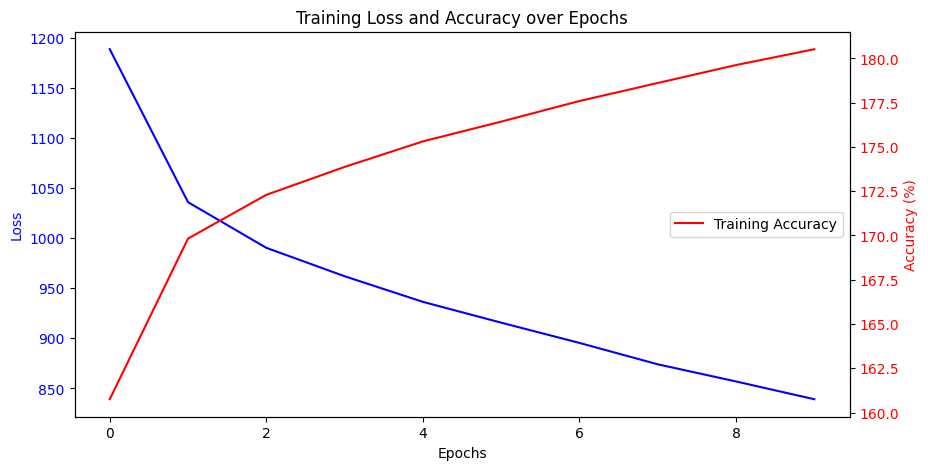

In [10]:
# Initialize a new figure for plotting with a specified size
plt.figure(figsize=(10, 5))
epochs = range(0, best_params["n_epochs"]) # Define the range of epochs based on the best hyperparameters

# Plot the training loss on the primary y-axis
plt.plot(epochs, train_losses, label='Training Loss', color='blue') # Plot training loss as a blue line
plt.xlabel('Epochs') # Label for the x-axis
plt.ylabel('Loss', color='blue') # Label for the primary y-axis, colored blue to match the loss plot
plt.tick_params(axis='y', labelcolor='blue') # Color the tick labels blue to match the loss plot

# Instantiate a second y-axis to plot training accuracy
ax2 = plt.twinx() # Create a twin of the original axes that shares the x-axis
ax2.plot(epochs, train_accuracies, label='Training Accuracy', color='red') # Plot training accuracy as a red line
ax2.set_ylabel('Accuracy (%)', color='red') # Label for the secondary y-axis, colored red to match the accuracy plot
ax2.tick_params(axis='y', labelcolor='red') # Color the tick labels red to match the accuracy plot

# Finalize the plot with a title, x-axis label, and legend
plt.title('Training Loss and Accuracy over Epochs') # Title of the plot
plt.xlabel('Epochs') # Label for the x-axis
plt.legend(loc='center right') # Position the legend on the plot

# Display the plot
plt.show()

We observe that as the number of epochs increases, the training loss is decreasing and the training accuracy is increasing. This is an expected trend when a model is learning from the data correctly. The model's loss decreasing signifies that it is getting better at predicting the output that matches the target values in the training dataset. Meanwhile, the increase in training accuracy indicates that the number of correct predictions made by the model is rising over time.

# Predict Test and Generate Submission File

This script illustrates the final step in a protein secondary structure prediction task, generating predictions for unseen test data and preparing a submission file. It leverages a trained model to predict the secondary structure ('H' for helix, 'E' for strand, and 'C' for coil) of each residue in protein sequences from the test dataset. The generate_predictions function processes the test dataset, utilizing the model to output predictions which are then translated from numerical indices to corresponding structure labels. These predictions, along with sequence identifiers, are used by the create_submission_dataframe function to create a pandas DataFrame. This DataFrame maps each residue in the test dataset to its predicted structure, formatted suitably for submission. Finally, the DataFrame is saved to a CSV file, completing the process of generating and formatting model predictions for evaluation or submission to a competition.

In [11]:
def generate_predictions(model, test_loader, device):
    """
    Generates predictions for each sequence in the test dataset using the trained model.

    Parameters:
    - model: The trained neural network model for making predictions.
    - test_loader: DataLoader providing the test dataset.
    - device: The computing device ('cuda' or 'cpu').

    Returns:
    - predictions: A list of predicted secondary structure labels for each residue in each sequence.
    - seq_ids_list: A list of sequence identifiers corresponding to each prediction.
    """
    model.eval() # Set the model to evaluation mode
    predictions = [] # List to store predictions
    seq_ids_list = [] # List to store sequence identifiers
    structure_labels = ['H', 'E', 'C'] # Mapping output indices to structure labels
    
    with torch.no_grad(): # Disable gradient computation
        for sequence_tensor, pssm_tensor, _, seq_ids_batch, seq_lengths_batch in test_loader:
            # Prepare the data and move to the designated device
            sequence_tensor = sequence_tensor.to(device).transpose(1, 2)
            pssm_tensor = pssm_tensor.to(device).transpose(1, 2)
            outputs = model(sequence_tensor, pssm_tensor) # Generate model predictions

            # Get predictions for each class (H, E, C)
            _, predicted_labels = torch.max(outputs, dim=1)
            predicted_labels = predicted_labels.cpu().numpy() # Move predictions to CPU

            # Convert numeric predictions to structure labels
            for i, single_sequence_labels in enumerate(predicted_labels):
                seq_id = seq_ids_batch[i] # Retrieve the sequence identifier
                actual_length = seq_lengths_batch[i] # Retrieve the actual sequence length
                sequence_predictions = [structure_labels[label] for label in single_sequence_labels[:actual_length]]
                predictions.append(sequence_predictions) 
                
                # Generate residue-specific sequence identifiers
                seq_ids_list.extend([f"{seq_id}_{j+1}" for j in range(actual_length)])
                
    return predictions, seq_ids_list

def create_submission_dataframe(seq_ids, test_predictions):
    """
    Creates a pandas DataFrame suitable for submission, mapping each residue to its predicted structure.

    Parameters:
    - seq_ids: List of sequence identifiers for each residue.
    - test_predictions: List of predicted structures for each residue.

    Returns:
    - submission_df: DataFrame with columns 'ID' and 'STRUCTURE' ready for submission.
    """
    
    submission_entries = [] # Initialize list to store submission entries
    i = 0 # Initialize counter
    for idx, prediction in enumerate(test_predictions):
        for residue_index, structure in enumerate(prediction):
            seq_id = seq_ids[i] # Retrieve the sequence identifier for the current residue
            i+=1
            submission_entries.append([seq_id, structure]) # Append the entry
    
    # Create DataFrame from the submission entries
    submission_df = pd.DataFrame(submission_entries, columns=['ID', 'STRUCTURE'])
    return submission_df

test_predictions, seq_ids = generate_predictions(model, test_loader, device) # Generate predictions
submission_df = create_submission_dataframe(seq_ids, test_predictions) # Create submission DataFrame
submission_df.to_csv("submission.csv", index=False) # Save DataFrame to CSV for submission

# Visualizing Importance using Captum 

Visualizing model predictions, especially in complex domains such as protein sequence analysis, is crucial for interpreting how models derive their conclusions. Captum, a model interpretability tool for PyTorch, facilitates such visualizations by highlighting the importance of input features (amino acids in sequences and their PSSM profiles) in model predictions. This approach sheds light on the model's decision-making process, revealing which parts of the input are most influential for predicting protein structures.

Visualizing Sequence and PSSM Importances:

* **Sequence Visualization:** Focuses on understanding the significance of each amino acid position in the protein sequence. This visualization helps identify critical regions within the sequence that heavily influence the model's structural classification.
* **PSSM Visualization:** Highlights the importance of evolutionary information at each sequence position. By examining the PSSM feature importances, we gain insights into which evolutionary contexts are deemed crucial by the model for accurate prediction.


The model_wrapper function adjusts the output of a neural network to focus on the predictions for a specific position within the input sequences. This adjustment is crucial for applying Captum's attribution methods effectively, allowing for detailed analysis of how different input features influence the model's predictions at a specified target position.

In [12]:
def model_wrapper(sequence_tensor, pssm_tensor):
    """
    Wraps the model output for a specific target position, making it compatible with Captum's attribution methods.

    Parameters:
    - sequence_tensor: Tensor containing encoded protein sequences.
    - pssm_tensor: Tensor containing Position-Specific Scoring Matrix (PSSM) profiles.

    Returns:
    - target_output: The model's output for a specific target position across all sequences in the batch.
    """
        
    target_position = 1 # Example target position for which to interpret the model's output
    # Obtain model predictions
    output = model(sequence_tensor, pssm_tensor)  # Shape: [batch_size, num_classes, sequence_length]
    # Select the output for the target position
    target_output = output[:, :, target_position]  # Shape: [batch_size, num_classes]
    return target_output


The visualize_importances function complements this analysis by offering a straightforward way to visualize the importance scores of different features. By presenting these scores in a bar chart, it provides clear insights into which features are most influential for the model's decisions.

In [13]:
def visualize_importances(feature_names, importances, title="Feature Importances", axis_title="Features"):
    """
    Visualizes the importances of different features using a bar chart.

    Parameters:
    - feature_names: A list of names corresponding to the features.
    - importances: A list or array of importance scores corresponding to each feature.
    - title: Title for the plot.
    - axis_title: Label for the x-axis.

    Returns:
    None. Displays a plot showing the importance of each feature.
    """
    
    x_pos = np.arange(len(feature_names)) # Determine the position of each bar
    plt.figure(figsize=(20, 6))  # Increase figure size for better readability
    plt.bar(x_pos, importances, align='center') # Create a bar chart
    
    plt.xticks(x_pos, feature_names, rotation='vertical') # Set feature names as x-axis labels, rotated for readability
    plt.xlabel(axis_title) # Set the label for the x-axis
    plt.title(title) # Set the title for the plot
    plt.show() # Display the plot


The provided code snippet demonstrates how to leverage the Integrated Gradients method from Captum to interpret a deep learning model's predictions, specifically focusing on protein secondary structure prediction. Integrated Gradients offers a way to attribute the prediction of a neural network to its input features, making it invaluable for understanding which parts of a protein sequence and its Position-Specific Scoring Matrix (PSSM) contribute most to the model's predictions.

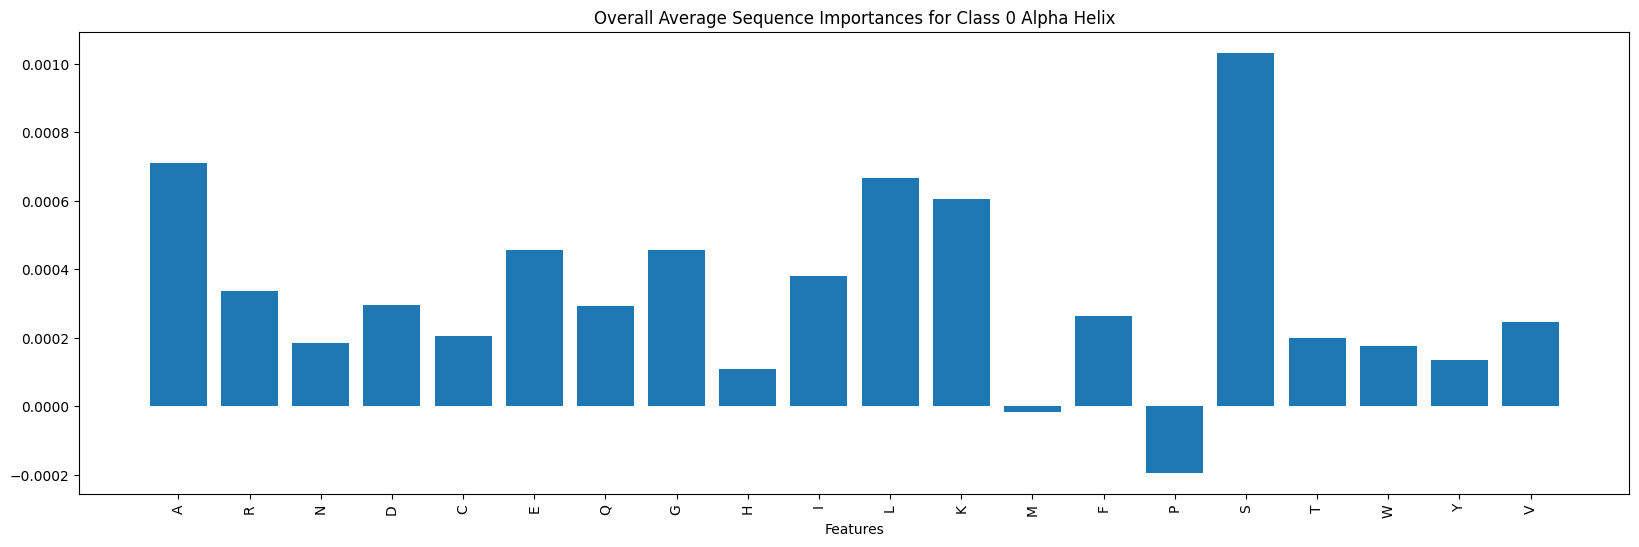

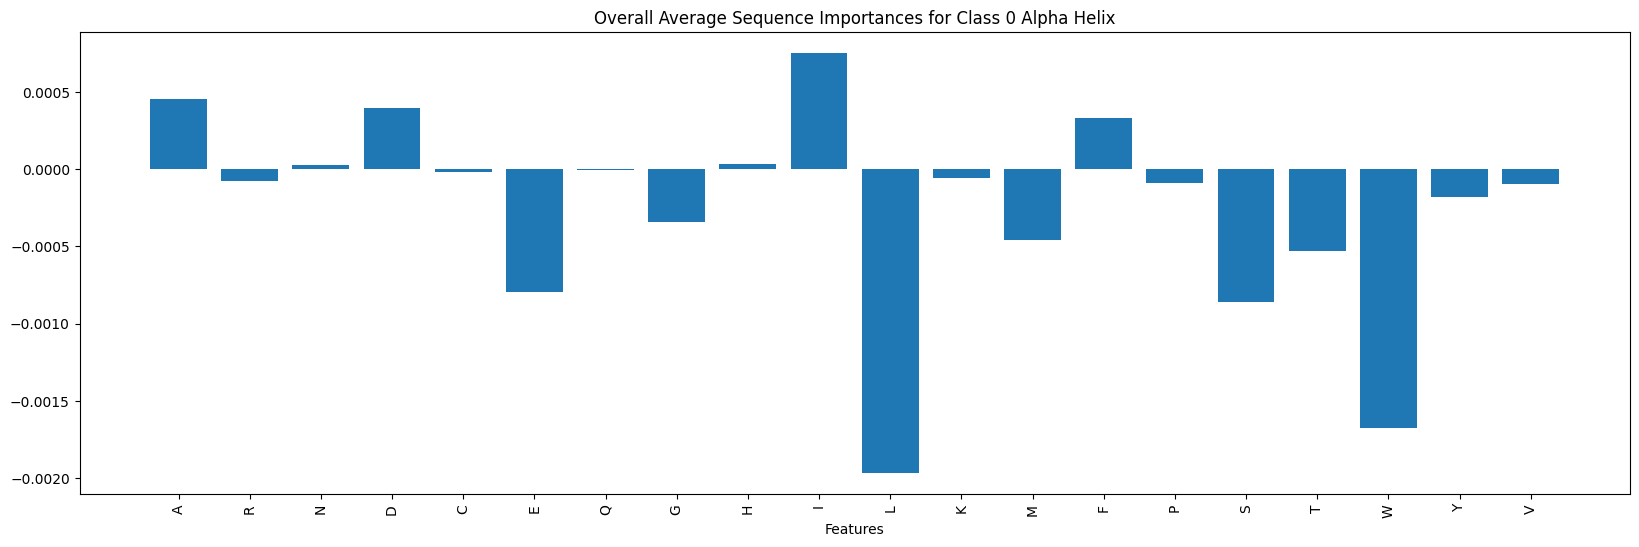

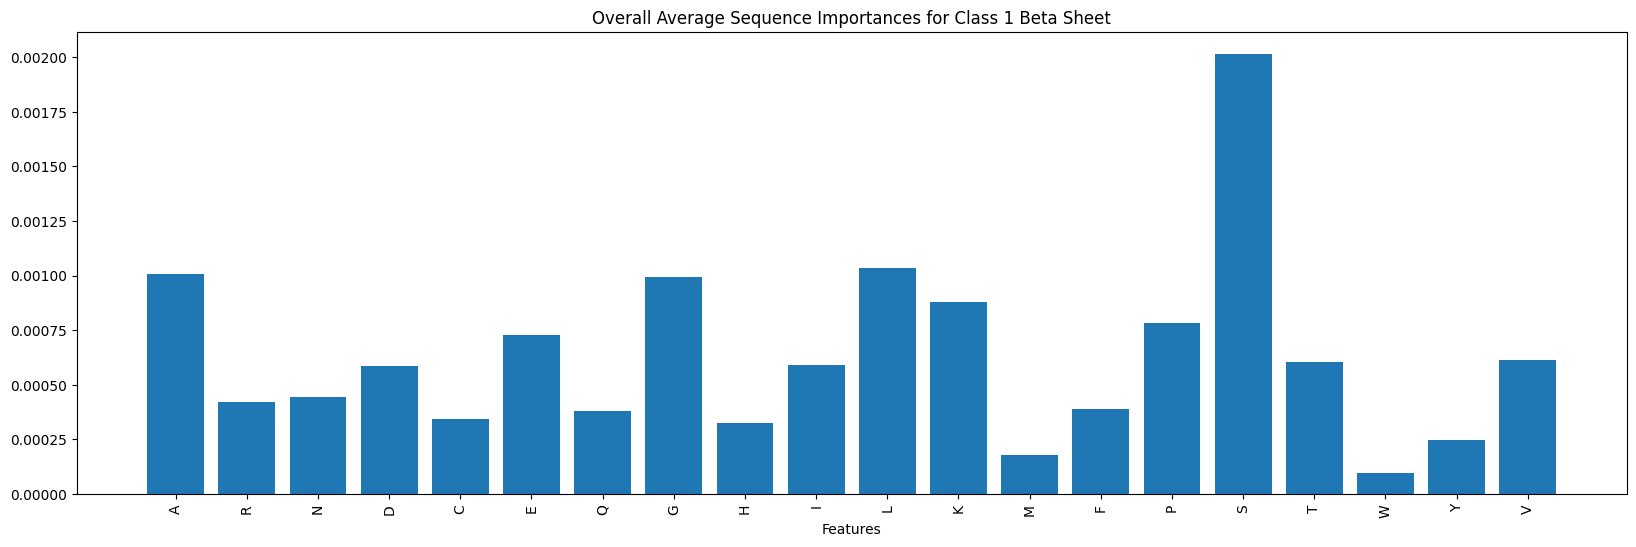

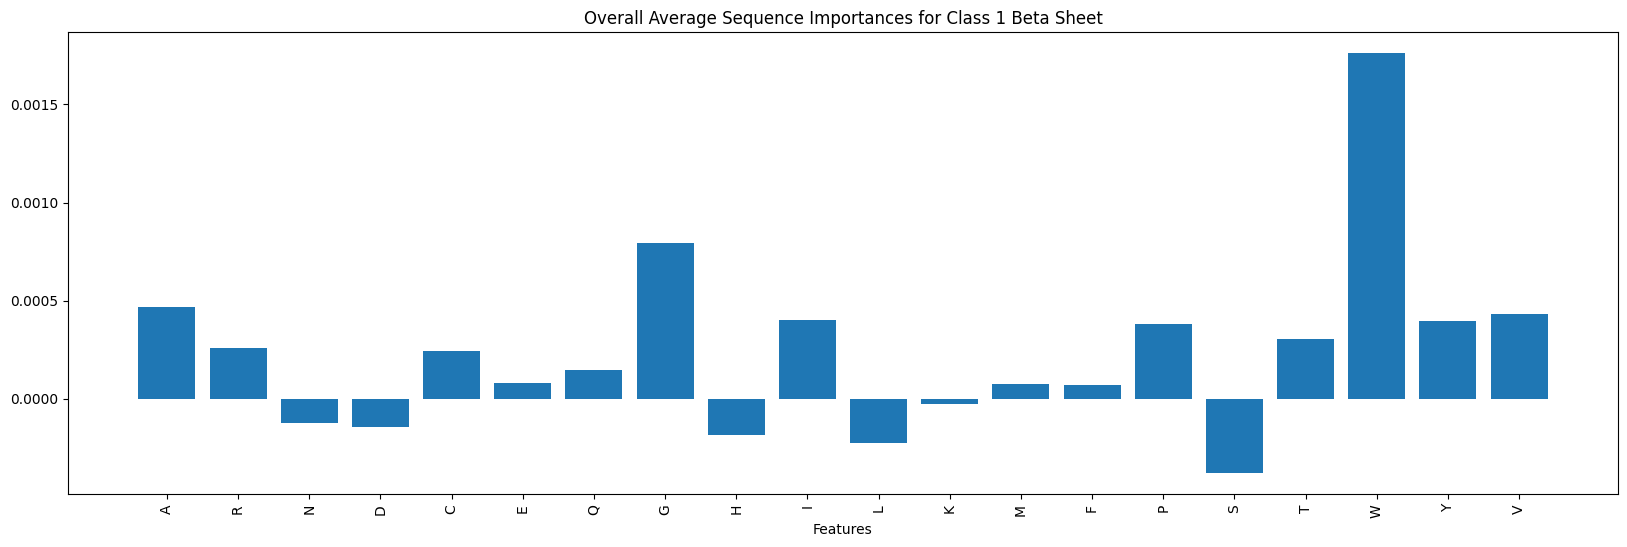

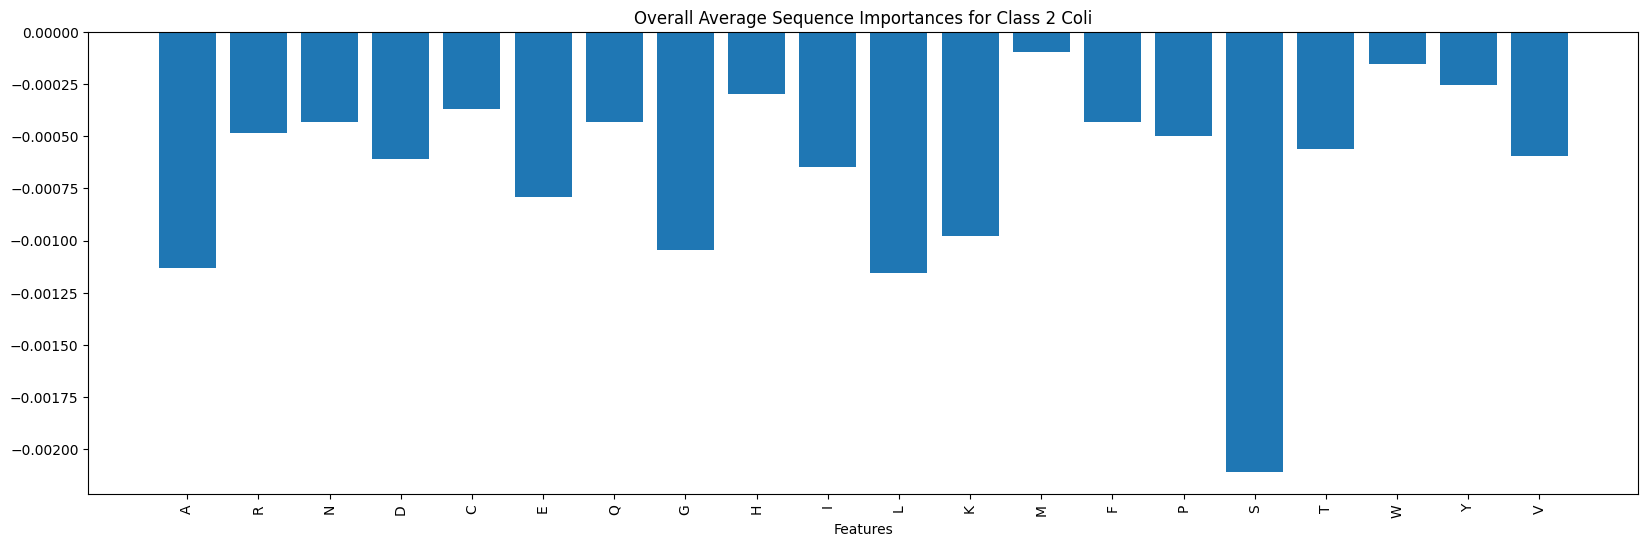

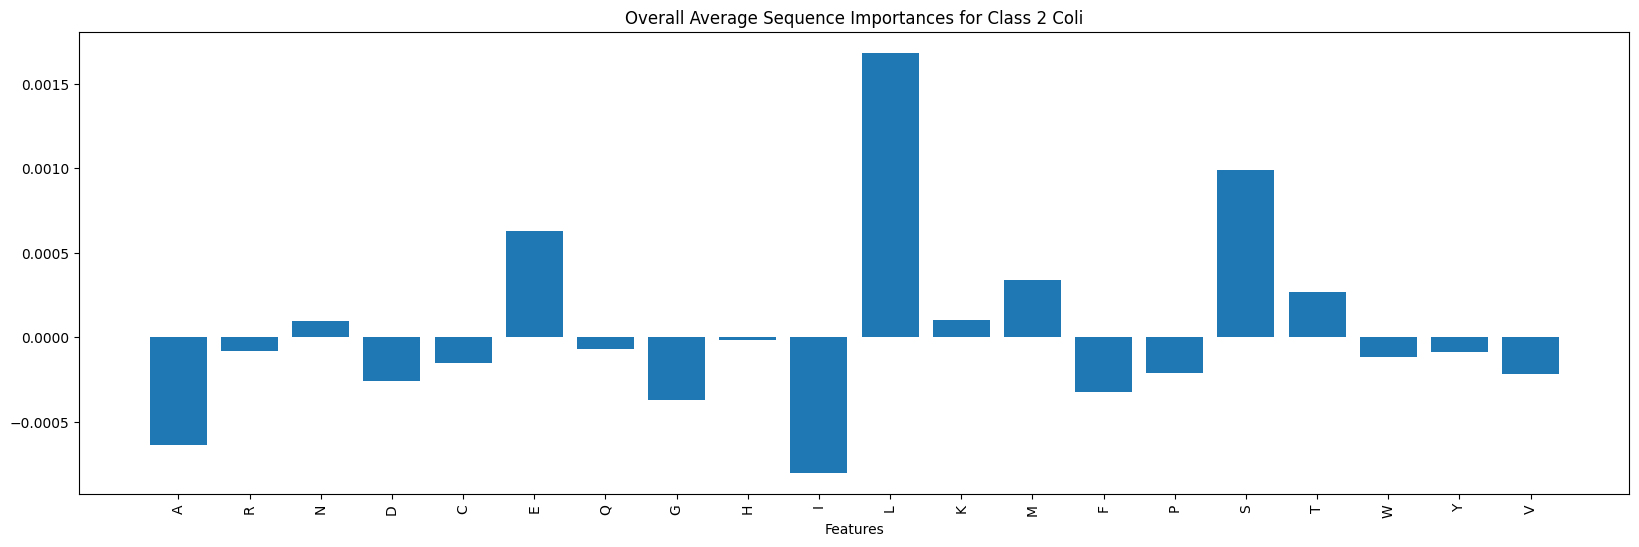

In [14]:
# Prepare the model and device for evaluation
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize Integrated Gradients with a model wrapper function
ig = IntegratedGradients(model_wrapper)

# Map amino acids to indices for easier handling
aa_to_index = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'E': 5, 'Q': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}

# Create a list of amino acids from the mapping
amino_acids = list(aa_to_index.keys())  # ['A', 'R', 'N', 'D', ..., 'V']

# Function to visualize importances for a specified target class
def visualize_importances_for_class(target_class):
    importances_sequence_scores = [] # Store sequence importance scores
    importances_pssm_scores = [] # Store PSSM importance scores
    titles = ["Alpha Helix", "Beta Sheet", "Coli"] # Titles for each secondary structure class
    title = titles[target_class] # Get the specific title for the target class

    # Iterate through the test dataset to compute importances
    for sequence_tensor, pssm_tensor, labels, seq_ids, seq_lengths in test_loader:
        # Prepare tensors and enable gradient computation
        sequence_tensor = sequence_tensor.to(device).transpose(1, 2)
        pssm_tensor = pssm_tensor.to(device).transpose(1, 2)
        sequence_tensor.requires_grad_()
        pssm_tensor.requires_grad_()

        # Compute attributions using Integrated Gradients
        attr_sequence, _ = ig.attribute(inputs=(sequence_tensor, pssm_tensor),
                                        target=target_class,
                                        additional_forward_args=(),
                                        return_convergence_delta=True)
        attr_sequence_tensor, attr_pssm_tensor = attr_sequence
        attr_sequence_array = attr_sequence_tensor.detach().cpu().numpy()
        attr_pssm_array = attr_pssm_tensor.detach().cpu().numpy()

        # Aggregate and calculate mean importances for both sequence and PSSM
        importances_sequence = attr_sequence_array.mean(axis=2)
        importances_pssm = attr_pssm_array.mean(axis=2)
        importances_sequence_scores.append(importances_sequence)
        importances_pssm_scores.append(importances_pssm)

    # Concatenate all importance scores and compute overall mean importance
    all_importances_sequence = np.concatenate(importances_sequence_scores, axis=0)
    all_importances_pssm = np.concatenate(importances_pssm_scores, axis=0)
    overall_mean_importance_sequence = np.mean(all_importances_sequence, axis=0)
    overall_mean_importance_pssm = np.mean(all_importances_pssm, axis=0)
    
    # Visualize the mean importances for sequence and PSSM features
    visualize_importances(amino_acids, overall_mean_importance_sequence, title=f"Overall Average Sequence Importances for Class {target_class} {title}")
    visualize_importances(amino_acids, overall_mean_importance_pssm, title=f"Overall Average PSSM Importances for Class {target_class} {title}")
    
    return (all_importances_sequence, all_importances_pssm)

# Visualizing importance for different classes
all_importances_sequence_0, all_importances_pssm_0 = visualize_importances_for_class(0)  # For alpha helix
all_importances_sequence_1, all_importances_pssm_1 = visualize_importances_for_class(1)  # For beta sheet
all_importances_sequence_2, all_importances_pssm_2 = visualize_importances_for_class(2)  # For coil


The plots is the bar charts representing the average importances of amino acid residues in protein sequences for the prediction of secondary structures such as alpha helices, beta sheets, and coils. These importances are  computed using a technique like Integrated Gradients, which is part of the model interpretability tools provided by libraries Captum.

This plot shows the importance of each amino acid in predicting the alpha helix, beta sheet and coli structure. The bar heights represent the importance scores, with positive values indicating a stronger influence on the prediction for target class. 

In the context of these plots, a strong positive importance score for an amino acid means that the model has learned that the presence of this amino acid is likely to increase the chance of the protein sequence forming the specific secondary structure being predicted. Conversely, a strong negative importance score indicates that the amino acid is likely to decrease the chance of the protein sequence adopting that particular secondary structure, according to the model's predictions.

**Overall Average Sequence Importances for Class 0 (Alpha Helix):**  
- Feature P (Proline) displays a strong negative importance in predicting the alpha helix structure. This means that in the context of the model's learning, the presence of proline is interpreted as reducing the likelihood of an alpha helix at that position in the protein sequence.
- Feature S (Serine) shows the strongest positive importance among the features. This indicates that, according to the model's learning, the presence of serine increases the likelihood of an alpha helix at that position in the protein sequence.

**Overall Average PSSM Importances for Class 0 (Alpha Helix):** 
- Feature L (Leucine) exhibits a strong negative importance in the context of PSSM profiles for predicting the alpha helix structure. This suggests that the model has learned that specific evolutionary patterns or profiles related to leucine are associated with a decreased likelihood of an alpha helix.
- Feature W (Tryptophan) also shows strong negative importance, indicating that the model has associated the evolutionary patterns or profiles related to tryptophan with a decreased likelihood of an alpha helix.
- Feature I (Isoleucine) has the strongest positive importance according to PSSM profiles, which suggests that the model has associated the evolutionary patterns or profiles related to isoleucine with an increased likelihood of an alpha helix.

**Overall Average Sequence Importances for Class 1 (Beta Sheet):** 
- All features contribute positively to the prediction of a beta sheet structure, with S (Serine) showing the strongest positive contribution among them.

**Overall Average PSSM Importances for Class 1 (Beta Sheet):** 
- S (Serine) shows a strong negative contribution across all features for predicting a beta sheet structure, while V (Valine) shows a strong positive contribution.

**Overall Average Sequence Importances for Class 2 (Coil):** 
- All features contribute negatively to the prediction of a coil structure, with S (Serine) showing the strongest negative contribution.

**Overall Average PSSM Importances for Class 2 (Coil):** 
- I (Isoleucine) and A (Alanine) show strong negative contributions, while L (Leucine) shows a strong positive contribution to the prediction of a coil structure.


# Distribution of Attributions for Each Feature  (In this context, each amino acid)

The visualize_attribution_histograms function creates detailed histograms for each amino acid in both sequence and PSSM data, showcasing the distribution of their importance scores. By generating separate histograms for each amino acid's sequence and PSSM attributions, it allows for a nuanced analysis of feature importance distributions. The histograms reveal which features consistently impact the model's decisions and which ones exhibit greater variability.

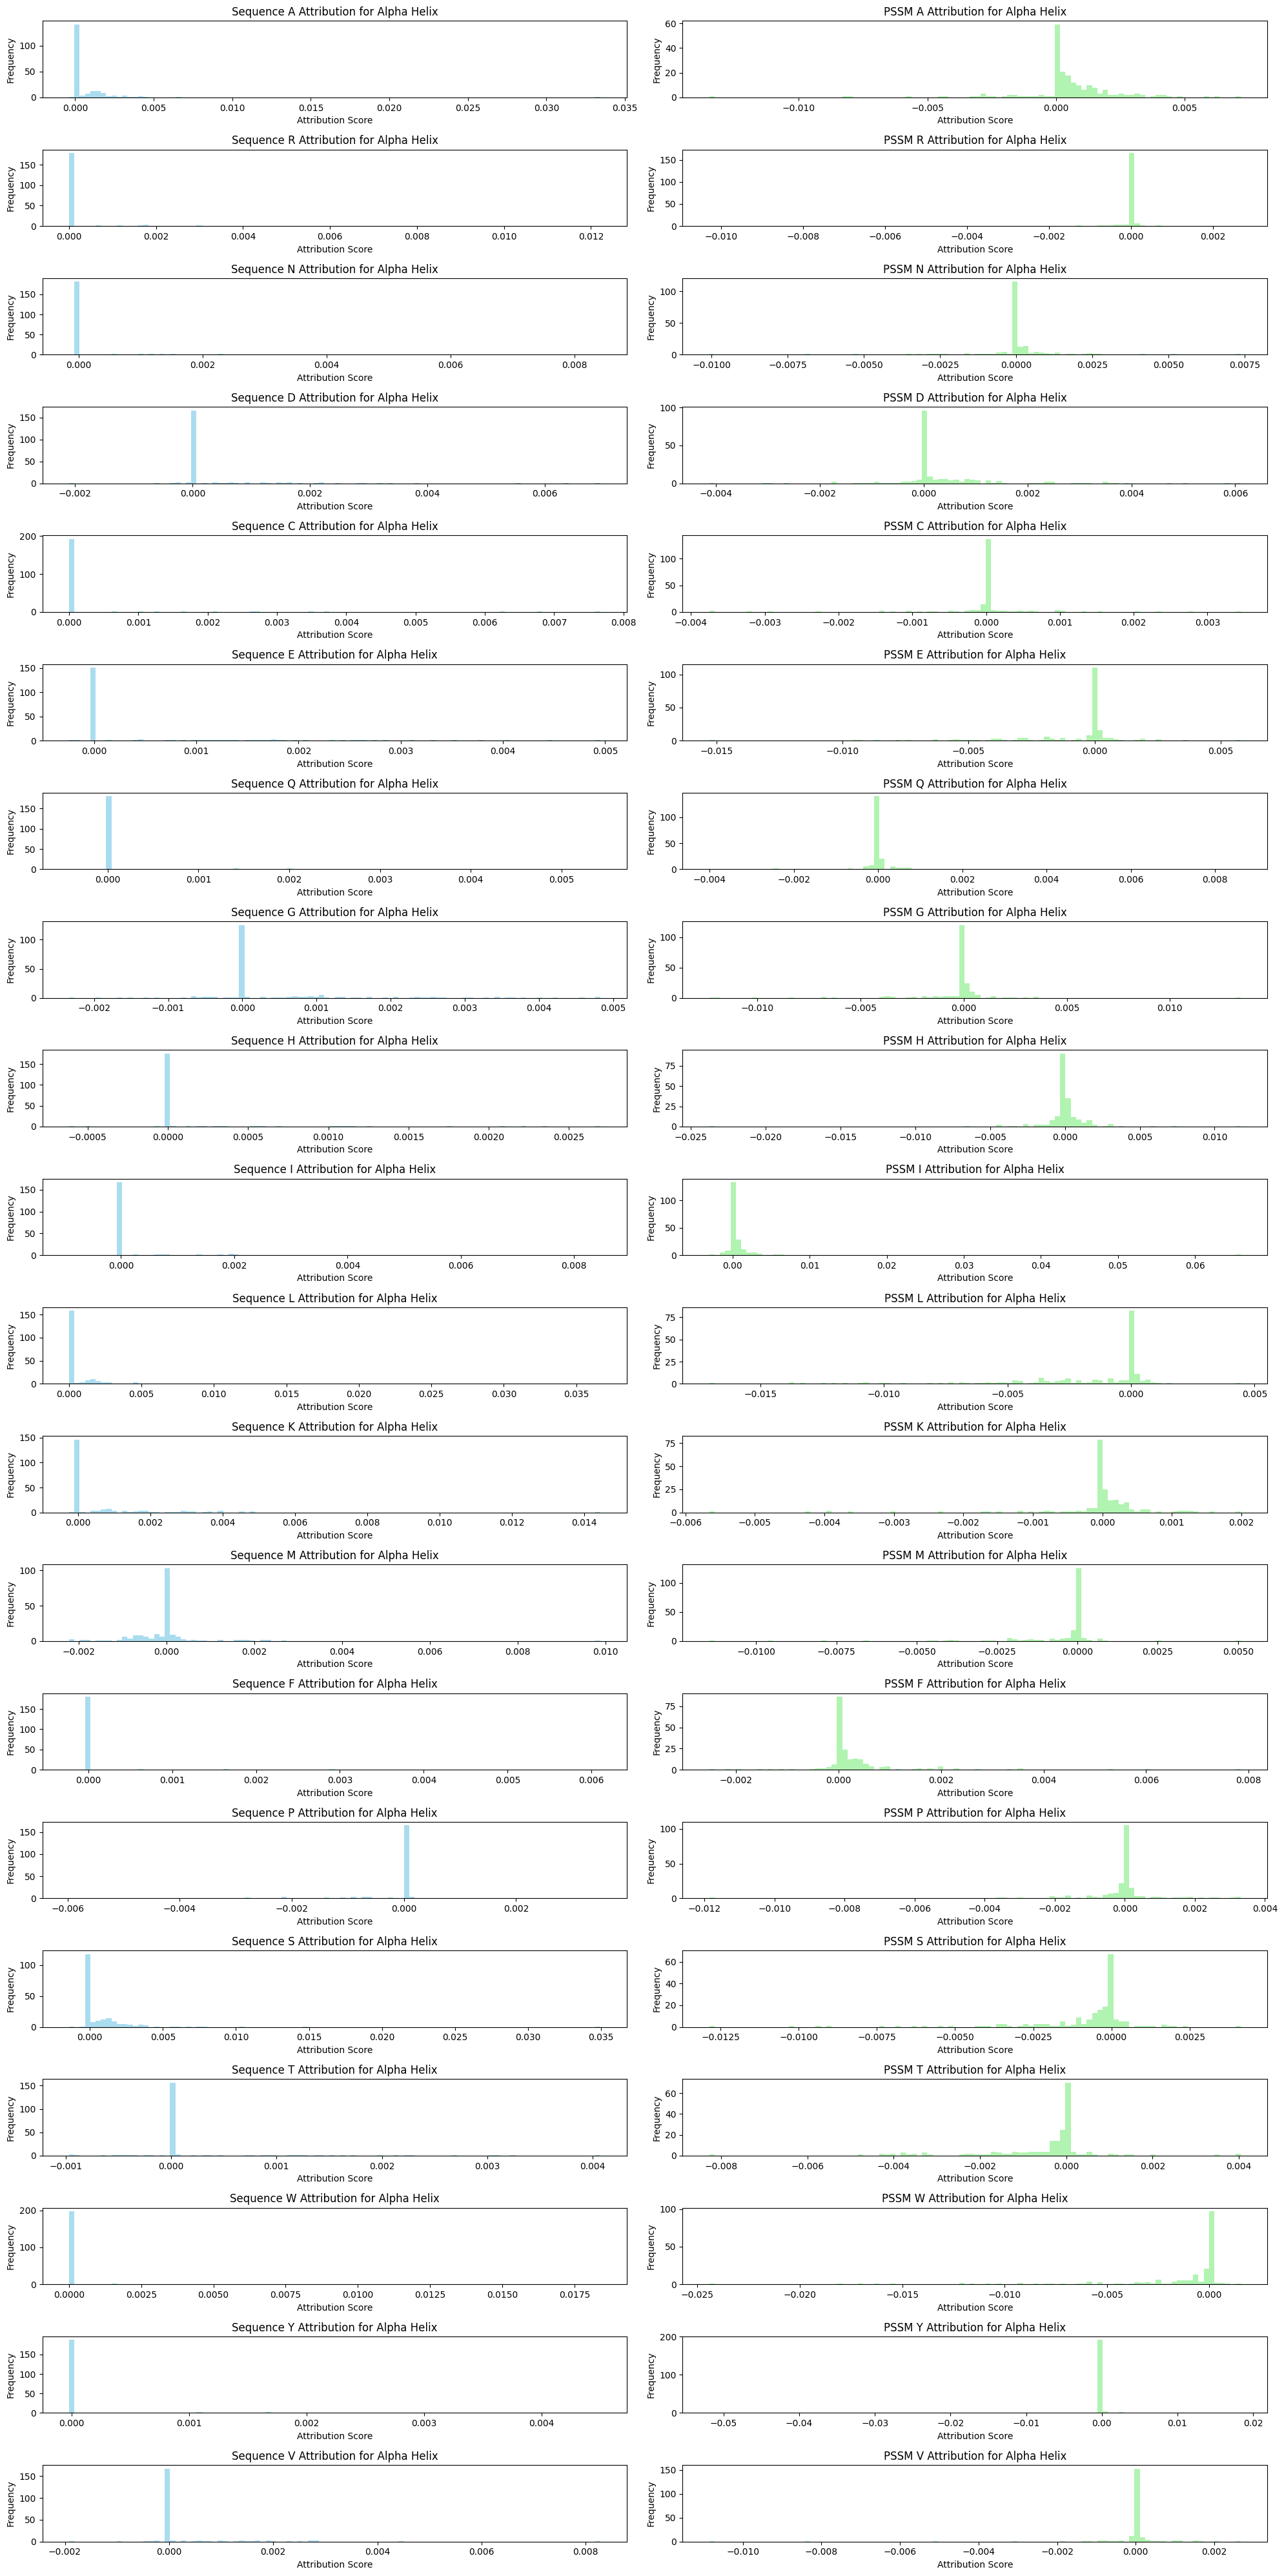

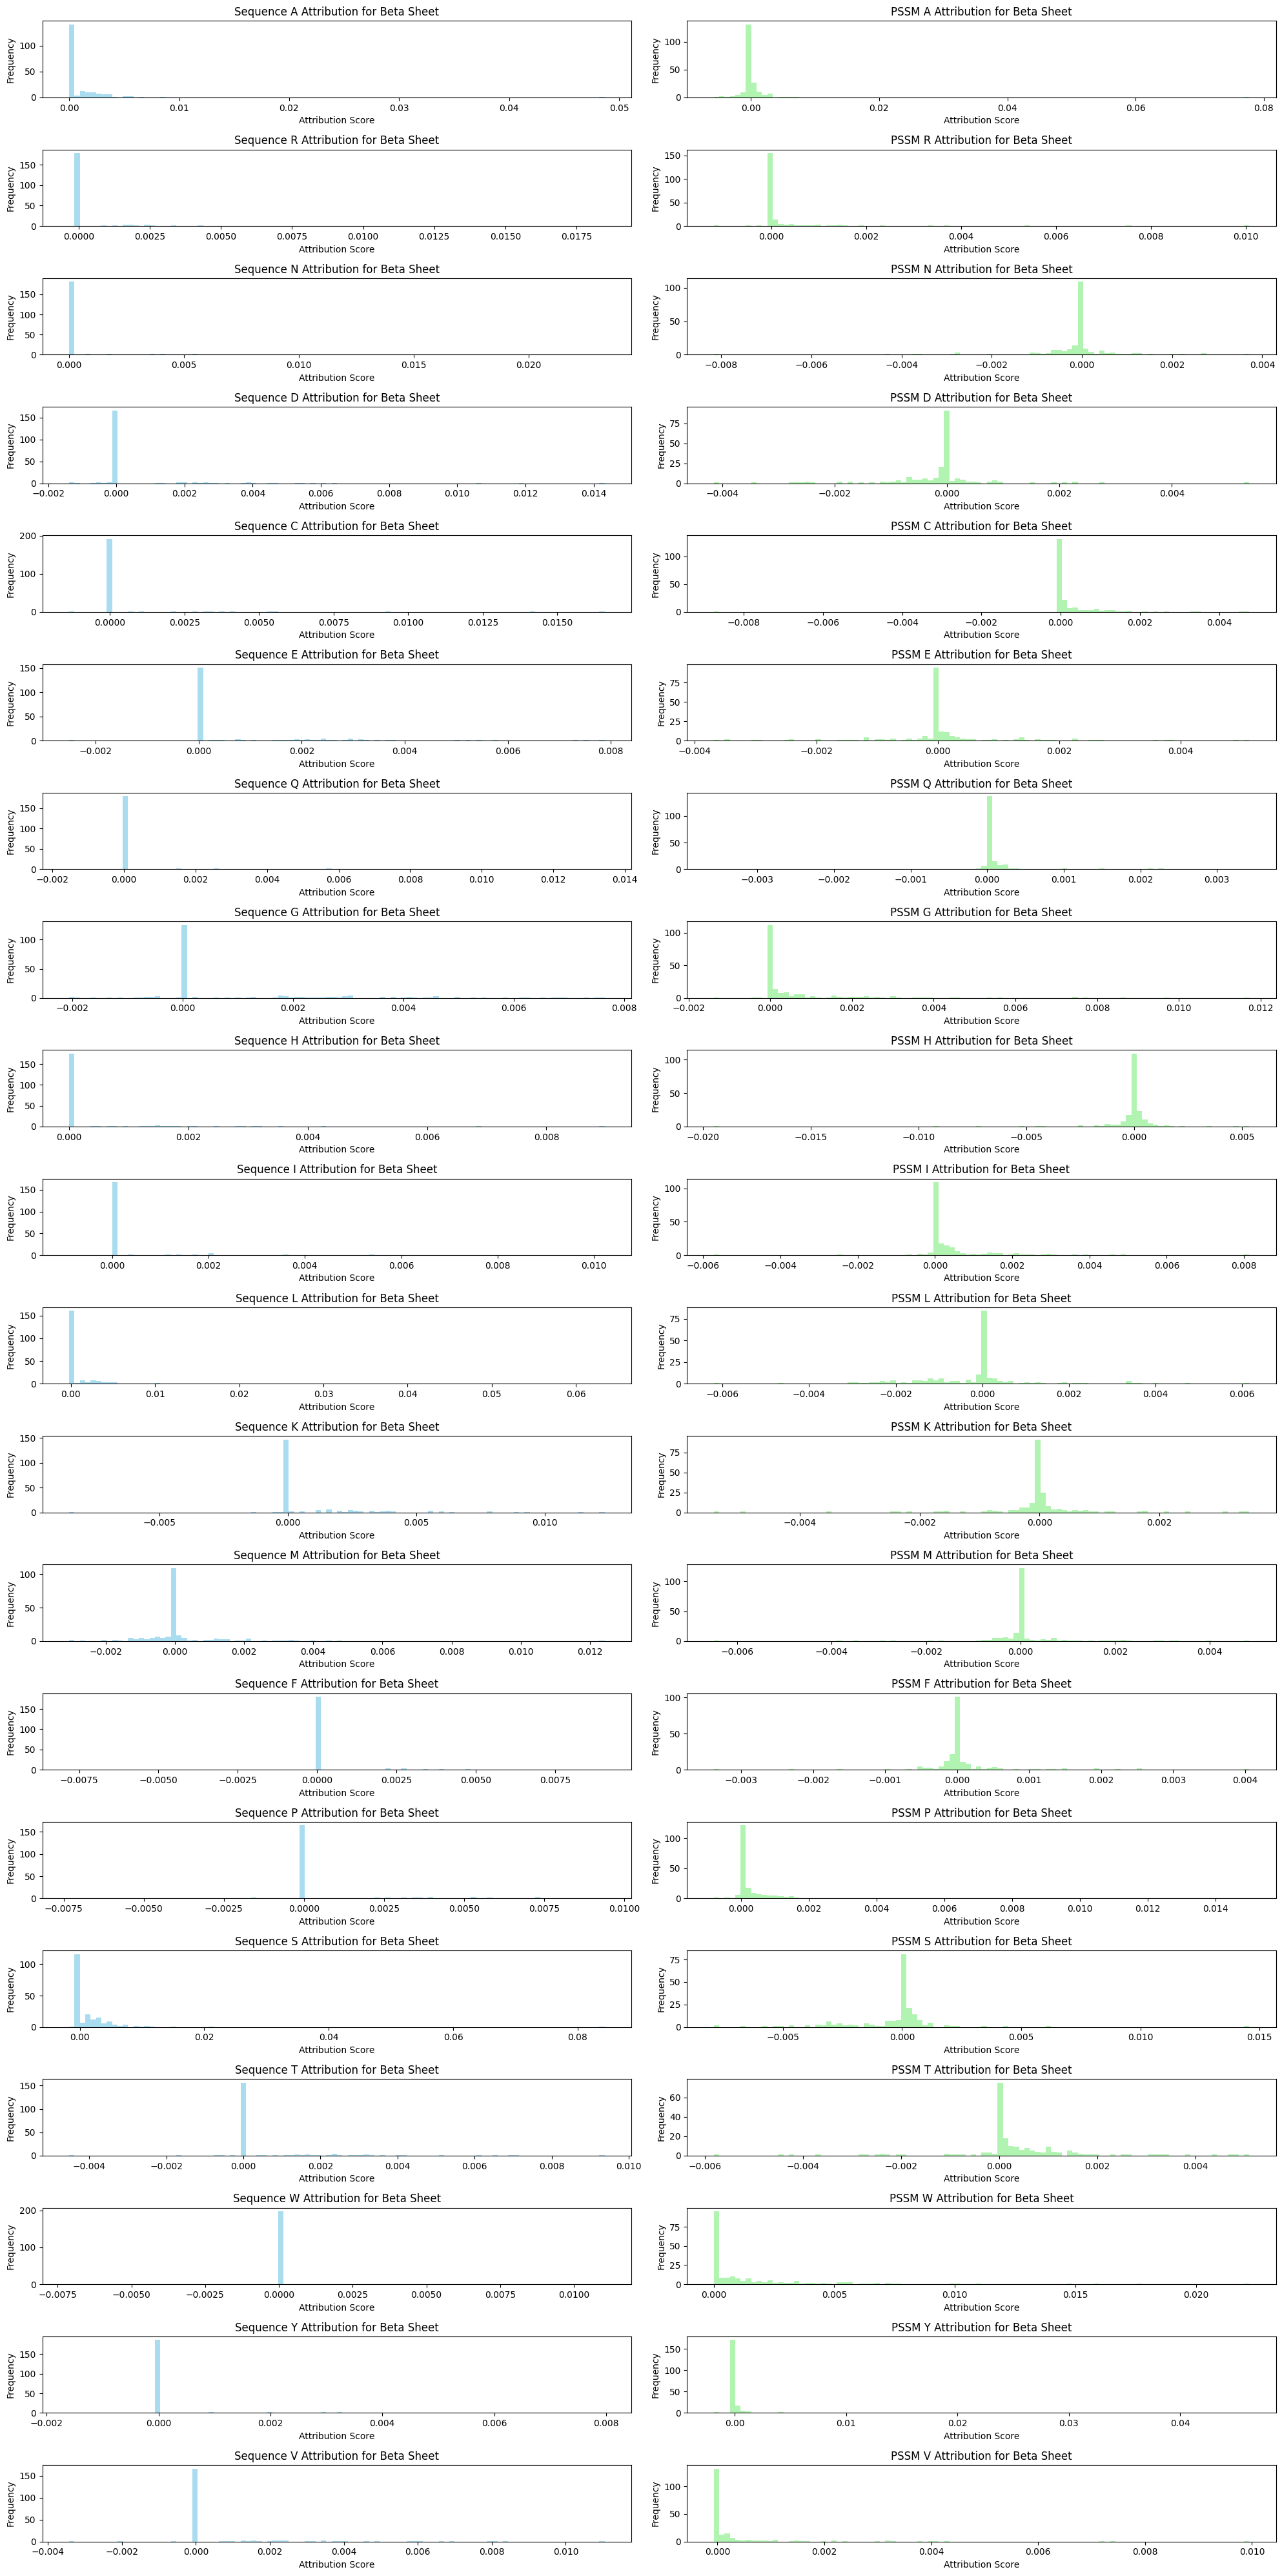

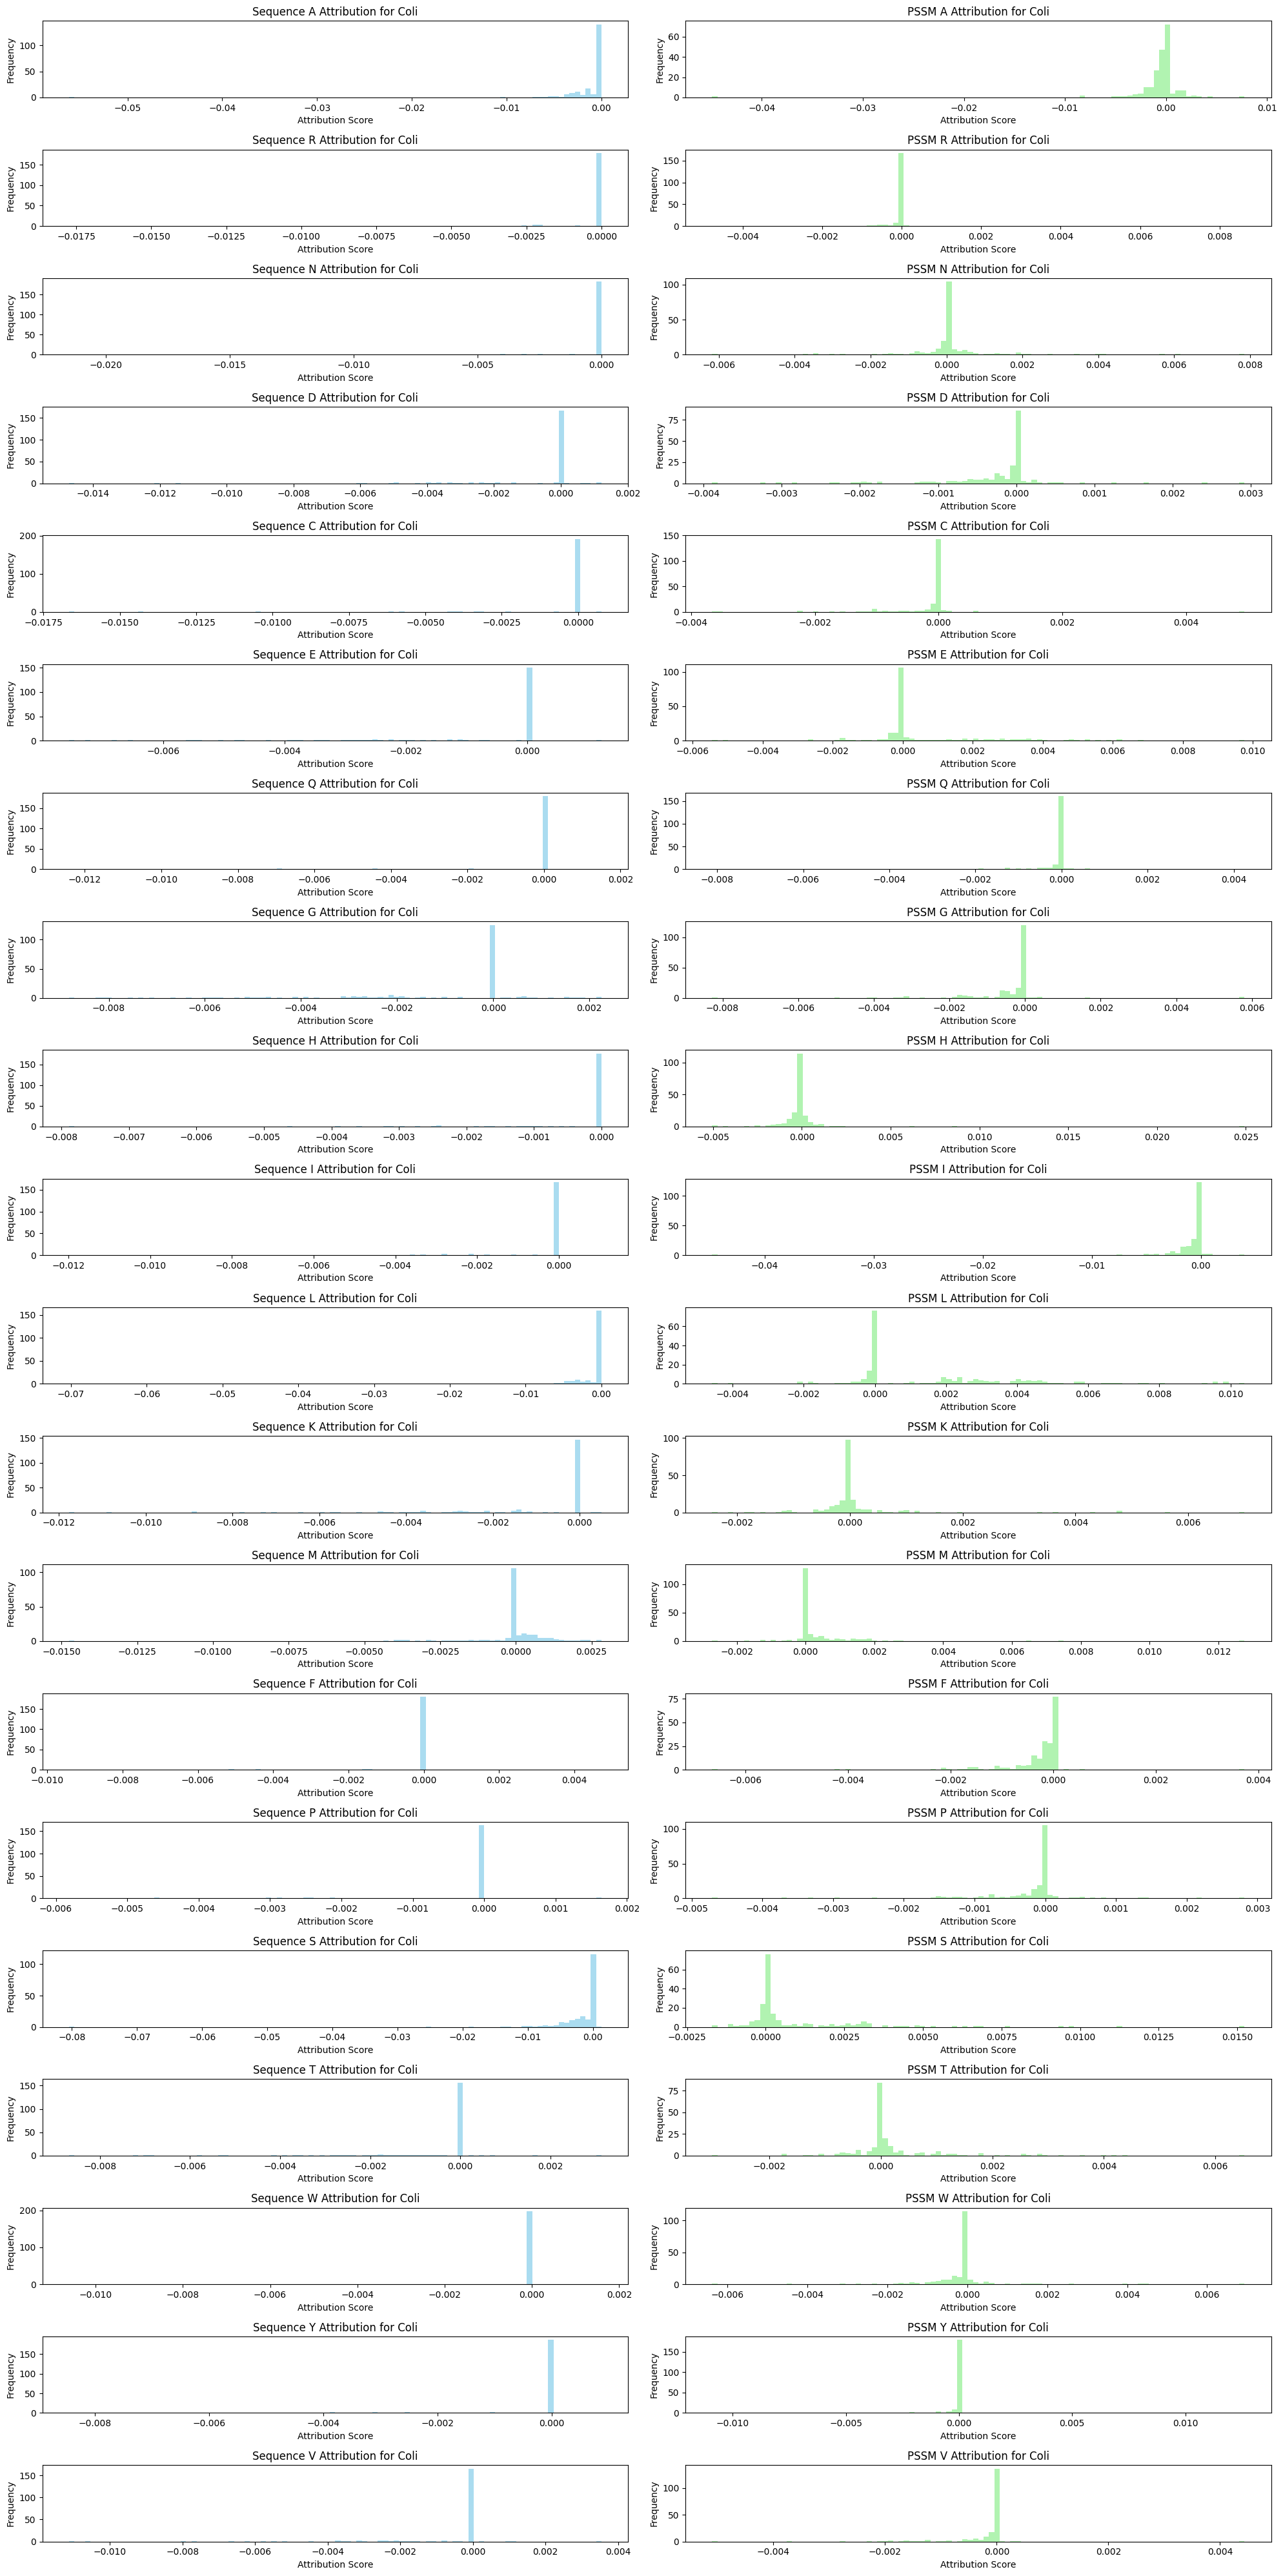

In [15]:
def visualize_attribution_histograms(all_importances_sequence, all_importances_pssm, title_suffix=""):
    """
    Generates histograms for the attribution scores of each amino acid in sequence and PSSM data.

    Parameters:
    - all_importances_sequence: Numpy array containing importance scores for each amino acid in the sequence data.
    - all_importances_pssm: Numpy array containing importance scores for each amino acid in the PSSM data.
    - title_suffix: Optional string to append to the title for specificity (e.g., "for Alpha Helix").
    """
    
    # Set up the figure size
    plt.figure(figsize=(20, 40))

    # Calculate the total number of subplots needed (two per amino acid, for sequence and PSSM)
    total_plots = len(amino_acids) * 2
    cols = 2 # Define the number of columns for subplots
    rows = total_plots // cols + (total_plots % cols > 0) # Calculate rows needed

    # Iterate through amino acids to create histograms for sequence attributions
    for i, aa in enumerate(amino_acids):
        plt.subplot(rows, cols, i*2+1)  # Position the subplot for sequence data
        plt.hist(all_importances_sequence[:, i], bins=100, alpha=0.7, color='skyblue') # Plot histogram
        plt.title(f"Sequence {aa} Attribution {title_suffix}") # Set title with amino acid and optional suffix
        plt.xlabel('Attribution Score') # Label for the x-axis
        plt.ylabel('Frequency') # Label for the y-axis

    # Repeat the process for PSSM data
    for i, aa in enumerate(amino_acids):
        plt.subplot(rows, cols, i*2+2)  # Position the subplot for PSSM data
        plt.hist(all_importances_pssm[:, i], bins=100, alpha=0.7, color='lightgreen') # Plot histogram
        plt.title(f"PSSM {aa} Attribution {title_suffix}") # Set title with amino acid and optional suffix
        plt.xlabel('Attribution Score') # Label for the x-axis
        plt.ylabel('Frequency') # Label for the y-axis

    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show() # Display the figure

# Visualizing attribution histrograms for different classes
visualize_attribution_histograms(all_importances_sequence_0, all_importances_pssm_0, title_suffix="for Alpha Helix")
visualize_attribution_histograms(all_importances_sequence_1, all_importances_pssm_1, title_suffix="for Beta Sheet")
visualize_attribution_histograms(all_importances_sequence_2, all_importances_pssm_2, title_suffix="for Coli")


**Sequence Attribution Histograms:**
Blue histograms represent sequence attribution scores for predicting protein secondary structures.
Skewness towards positive indicates a favorable contribution to the class prediction:
- **Alpha Helix & Beta Sheet:** Mostly skewed left, indicating a generally negative contribution.
- **Coil:** Skewed right, suggesting a positive contribution.

**PSSM Attribution Histograms:**
Green histograms show PSSM attribution scores, reflecting evolutionary contributions to predictions.
Positive attribution implies evolutionary support for the structure, while negative implies opposition:
- **Alpha Helix:** Mostly skewed right, suggesting strong evolutionary support.
- **Beta Sheet:** Tend to skew left, indicating less evolutionary support.
- **Coil:** More central, with a mix of left and right skew, indicating varied evolutionary influences.

The plot_average_attribution_by_aa function visualizes the average importance scores of each amino acid in contributing to the model's predictions. By displaying these importances as a scatter plot, with the size of each dot proportional to the frequency of the corresponding amino acid, this visualization provides insights into which amino acids are deemed most important by the model for predicting protein secondary structures.

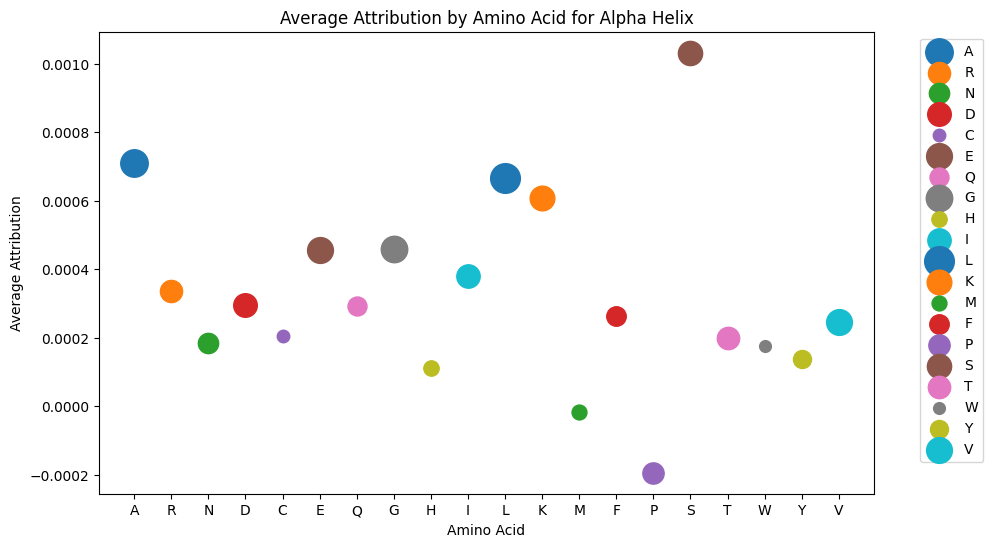

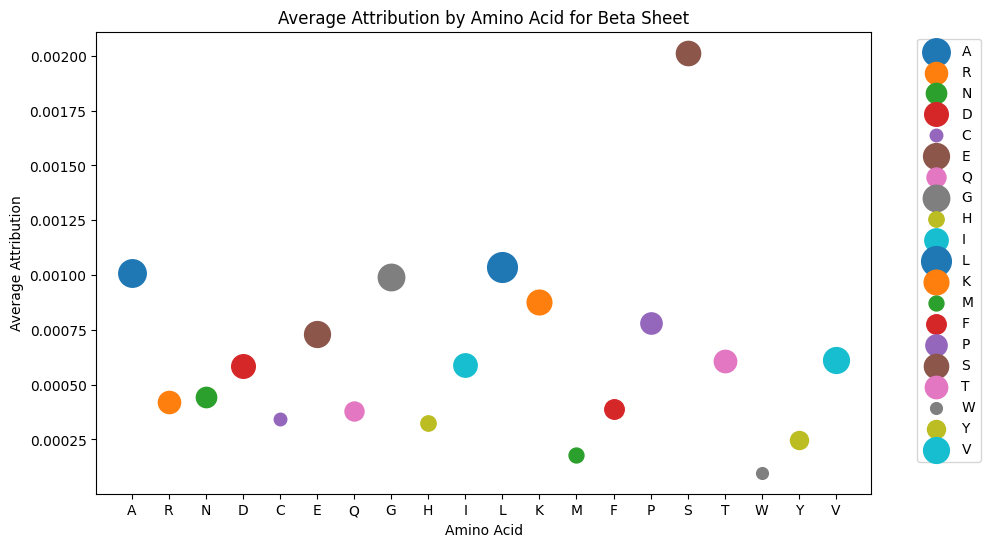

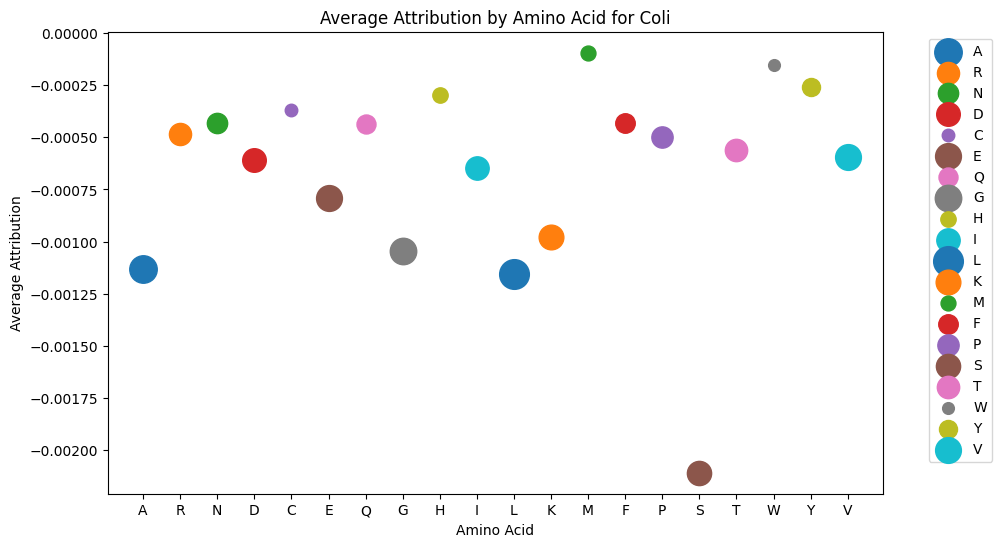

In [16]:
def plot_average_attribution_by_aa(all_importances_sequence, title="Average Attribution by Amino Acid"):
    """
    Creates a scatter plot to visualize the average importance scores attributed to each amino acid by the model.
    
    Parameters:
    - all_importances_sequence: np.array containing the importance scores for each amino acid across sequences.
    - title: str, the title of the plot, indicating the context of the visualization.
    """
    
    # Initialize an array to hold the total counts for each amino acid
    aa_counts = np.zeros(len(amino_acids))
    
    # Aggregate the counts of each amino acid across all sequences in the DataLoader
    for sequence_tensor, pssm_tensor, labels, seq_ids, seq_lengths in test_loader:
        # Sum the occurrences of each amino acid across the batch and accumulate
        aa_counts_batch = sequence_tensor.sum(dim=(0, 1)).cpu().numpy()
    
        # Accumulate counts
        aa_counts += aa_counts_batch
    
    aa_counts = np.array(aa_counts) # Convert to numpy array for processing

    # Calculate frequencies of each amino acid to normalize their counts
    aa_frequencies = aa_counts / np.sum(aa_counts)
    scaled_frequencies = 4000 * aa_frequencies  # Scale frequencies for visualization purposes
    
    # Compute mean importance for each amino acid
    overall_mean_importance_sequence = np.mean(all_importances_sequence, axis=0)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot each amino acid's average importance with the dot size representing its frequency
    for i, aa in enumerate(amino_acids):
        # Use the count of each amino acid as the size of the dot
        plt.scatter(i, overall_mean_importance_sequence[i], s=5000*aa_frequencies[i], label=aa)  # Adjust size factor as needed

    # Customize the plot with labels, title, and legend
    plt.xticks(np.arange(len(amino_acids)), amino_acids)
    plt.xlabel("Amino Acid")
    plt.ylabel("Average Attribution")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Visualizing average attribution by amino acid for different classes
plot_average_attribution_by_aa(all_importances_sequence_0, title="Average Attribution by Amino Acid for Alpha Helix")
plot_average_attribution_by_aa(all_importances_sequence_1, title="Average Attribution by Amino Acid for Beta Sheet")
plot_average_attribution_by_aa(all_importances_sequence_2, title="Average Attribution by Amino Acid for Coli")


- The x-axis lists the amino acids by their single-letter codes, while the y-axis shows the average attribution score for each amino acid.
- The size of each dot represents the frequency of the corresponding amino acid in the dataset, with larger dots indicating a higher occurrence.

**Average Attribution by Amino Acid for Alpha Helix** visualizes the mean importance scores attributed to each amino acid by the model when predicting the presence of alpha helices in protein sequences.
- Most amino acids have a positive average attribution, suggesting that they generally contribute favorably to the prediction of an alpha helix.
- A few amino acids have negative average attributions, suggesting that they might be less conducive to forming an alpha helix according to the model's learned patterns.

**Average Attribution by Amino Acid for Beta Sheet** depicts the mean importance scores assigned to each amino acid when predicting the beta sheet secondary structure in protein sequences.
- Most amino acids appear to have a positive attribution, suggesting that, on average, they are considered by the model to contribute to the formation of beta sheets.

**Average Attribution by Amino Acid for Coil** displays the average importance scores assigned to each amino acid when predicting coil regions within protein sequences.
- Most amino acids have negative average attribution scores, implying that their presence is generally predicted to decrease the likelihood of a region being classified as a coil by the model.
- The overall trend suggests that the model may be associating certain amino acids with a lower propensity to form coil structures, or this could reflect a bias in the training dataset.